# **1. Project Overview**

### *Project Description*
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. This project generates images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

The task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### *Dataset Description*

The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.

The `monet` directories contain Monet paintings. These images will be used to train the model. The `photo` directories contain photos that are to be transformed to Monet-style.

#### **Files**
- **monet_jpg:** 300 Monet paintings sized 256x256 in JPEG format
- **monet_tfrec:** 300 Monet paintings sized 256x256 in TFRecord format
- **photo_jpg:** 7028 photos sized 256x256 in JPEG format
- **photo_tfrec:** 7028 photos sized 256x256 in TFRecord format

---

# **2. Project Setup**

In [3]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [4]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [5]:
# SET NOTEBOOK FORMATTING OPTIONS
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]

**JPG IMAGES**

In [6]:
# JPG Monet and photo directories
monet_jpg_path = '../input/im-something-of-a-painter-myself/monet_jpg'
photo_jpg_path = '../input/im-something-of-a-painter-myself/photo_jpg'

In [7]:
# Function for retrieving image paths from directories
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [8]:
monet_jpg = image_path(monet_jpg_path)
photo_jpg = image_path(photo_jpg_path)

**TFREC IMAGES**

In [9]:
# TFREC Monet and photo directories
monet_tfrec_path = tf.io.gfile.glob('../input/im-something-of-a-painter-myself/monet_tfrec/*.tfrec')
photo_tfrec_path = tf.io.gfile.glob('../input/im-something-of-a-painter-myself/monet_tfrec/*.tfrec')

In [10]:
# Functions for loading in TFREC datasets with images

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [11]:
monet_tfrec = load_dataset(monet_tfrec_path, labeled=True).batch(1)
photo_tfrec = load_dataset(photo_tfrec_path, labeled=True).batch(1)

---

# **3. Exploratory Data Analysis (EDA)**

In [14]:
# Number of images in Monet and photo datasets
print("Number of Monet Images: ", len(monet_jpg))
print("Number of Photo Images: ", len(photo_jpg))

Number of Monet Images:  300
Number of Photo Images:  7038


In [15]:
# Function for displaying images
def display(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

**Monet Images**

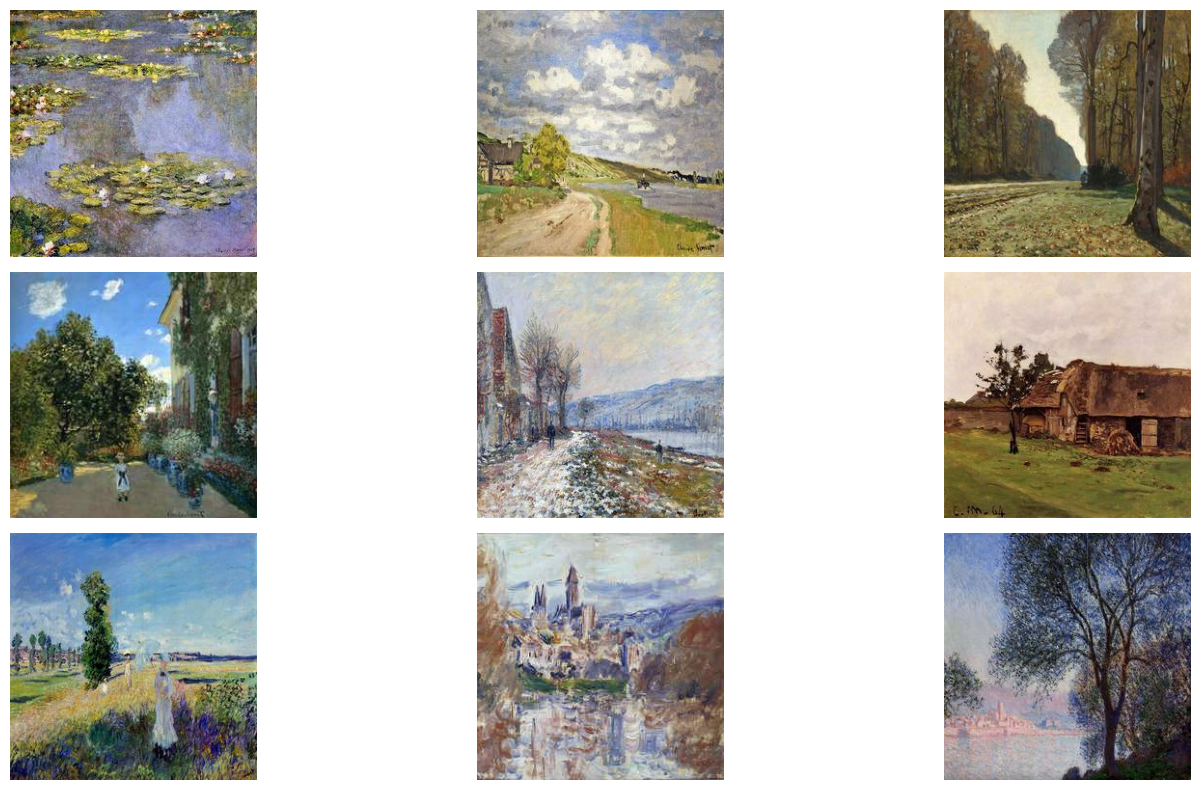

In [16]:
# Display Monet images
display(monet_jpg, 3, 3)

**Photo Images**

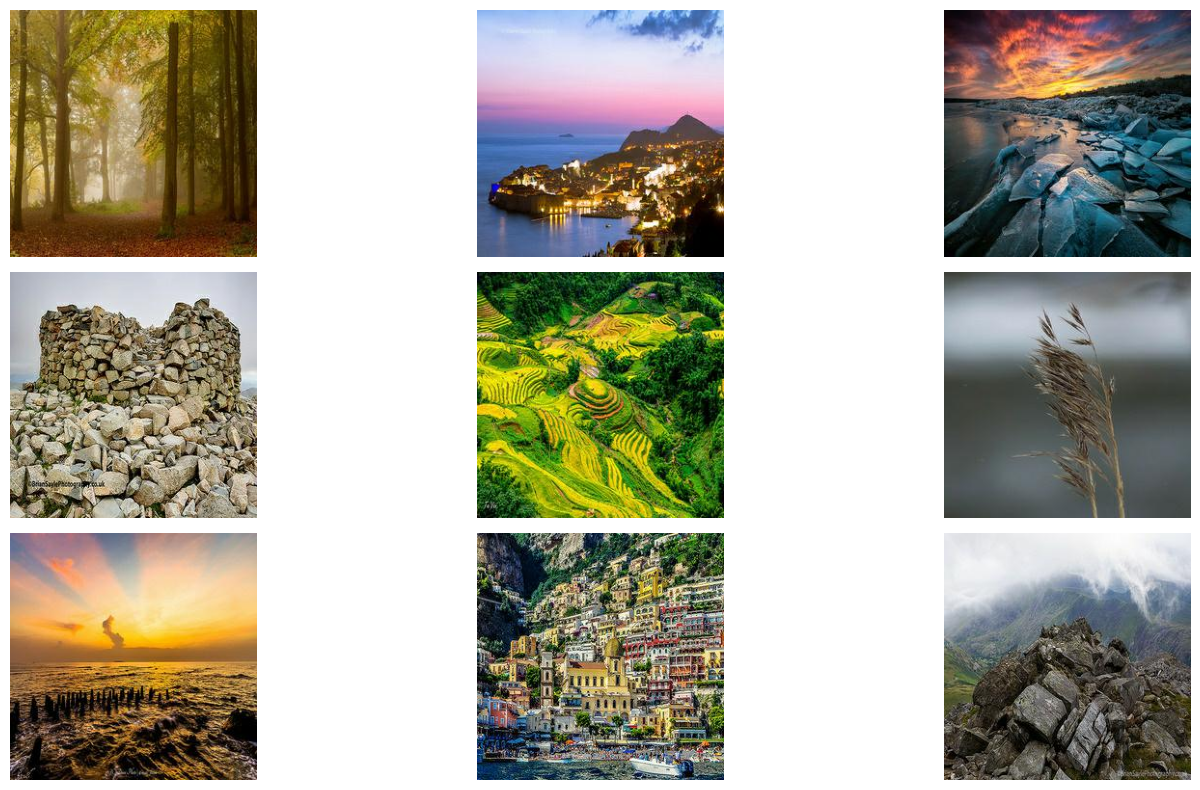

In [17]:
# Display photo images
display(photo_jpg, 3, 3)

---

# **4. Generator**
Build image generator.

In [18]:
OUTPUT_CHANNELS = 3

**Downsample Function:** *Reduce height and width of images by stride of 2.*

In [19]:
# Downsample function
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

**Upsample Function:** *Increase height and width of images by stride of 2.*

In [20]:
# Upsample function
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result


**Generator Function:** *Produce images that discriminator will classify as either real or generated by downsampling and then upsampling the input images. Skip connections are used in the upsample stage of the function to deal with the problem of vanishing gradients.*

In [21]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [22]:
# Additional generator functions
monet_generator = Generator() # transforms photos into Monet-style paintings
photo_generator = Generator() # transforms Monet-style pintings into photos

---

# **5. Discriminator**

**Discriminator Function:** *Discriminator function takes an image from the generator and determines whether or not it is real. The output of the discriminator function is another image – if the output image has higher pixel values, the discriminator has determined the input image to be real. If the output image has lower pixel values, the discriminator has determined the input image to be fake.*

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [20]:
# Additional discriminator functions
monet_discriminator = Discriminator() # determines if image is real Monet or generated painting
photo_discriminator = Discriminator() # determined if image is real or generated photo 

---

In [21]:
# Add to distribution strategies
with strategy.scope():
    monet_generator
    photo_generator
    monet_discriminator
    photo_discriminator

---

# **6. CycleGAN**
Using Cycle-Consistent Generative Adversarial Network (CycleGAN) model for image-to-image and style translation. CycleGAN allows image translation from one domain to another when there is no direct correspondence or paired data between the two domains for training, such as in this problem.

CycleGAN is especially useful for the task of converting the style of an image from a photograph to a painting and changing the characteristcs of an image for the output.

### **6.1 CycleGAN Class**

In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            
            # Photo -> Monet -> Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet -> Photo -> Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator; real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator; fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Evaluate generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluate discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### **6.2 Loss Function**

In [23]:
# Add to distribution strategies
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss   

### **6.3 Model Training**

In [24]:
# Add to distribution strategies
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )    

In [25]:
# Fit model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_tfrec, photo_tfrec)),
    epochs=30
)

Epoch 1/30


2023-09-26 22:59:03.493285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 143s 251ms/step - monet_gen_loss: 5.0725 - photo_gen_loss: 5.0226 - monet_disc_loss: 0.5948 - photo_disc_loss: 0.6170
Epoch 2/30
300/300 [==============================] - 75s 250ms/step - monet_gen_loss: 3.6222 - photo_gen_loss: 3.6167 - monet_disc_loss: 0.6774 - photo_disc_loss: 0.6799
Epoch 3/30
300/300 [==============================] - 75s 250ms/step - monet_gen_loss: 3.5119 - photo_gen_loss: 3.4312 - monet_disc_loss: 0.6324 - photo_disc_loss: 0.6899
Epoch 4/30
300/300 [==============================] - 75s 250ms/step - monet_gen_loss: 3.3992 - photo_gen_loss: 3.2908 - monet_disc_loss: 0.6775 - photo_disc_loss: 0.6905
Epoch 5/30
300/300 [==============================] - 75s 250ms/step - monet_gen_loss: 3.0894 - photo_gen_loss: 3.0445 - monet_disc_loss: 0.6760 - photo_disc_loss: 0.6768
Epoch 6/30
300/300 [==============================] - 75s 250ms/step - monet_gen_loss: 2.9057 - photo_gen_loss: 2.8685 - monet_disc_loss: 0.6849 - photo_di

---

# **7. Results**

The best CycleGAN model results were:
* **monet_gen_loss:** 1.8612 (Epoch 30)
* **photo_gen_loss:**  1.9793 (Epoch 30)
* **monet_disc_loss:** 0.5948 (Epoch 1)
* **photo_disc_loss:** 0.6170 (Epoch 1)

The CycleGAN model performed best at a greater number of epochs (30), while the discriminator performed best at the earlier epochs (1).

**Results Visualized:** *Visualize the new images in Monet-style.*

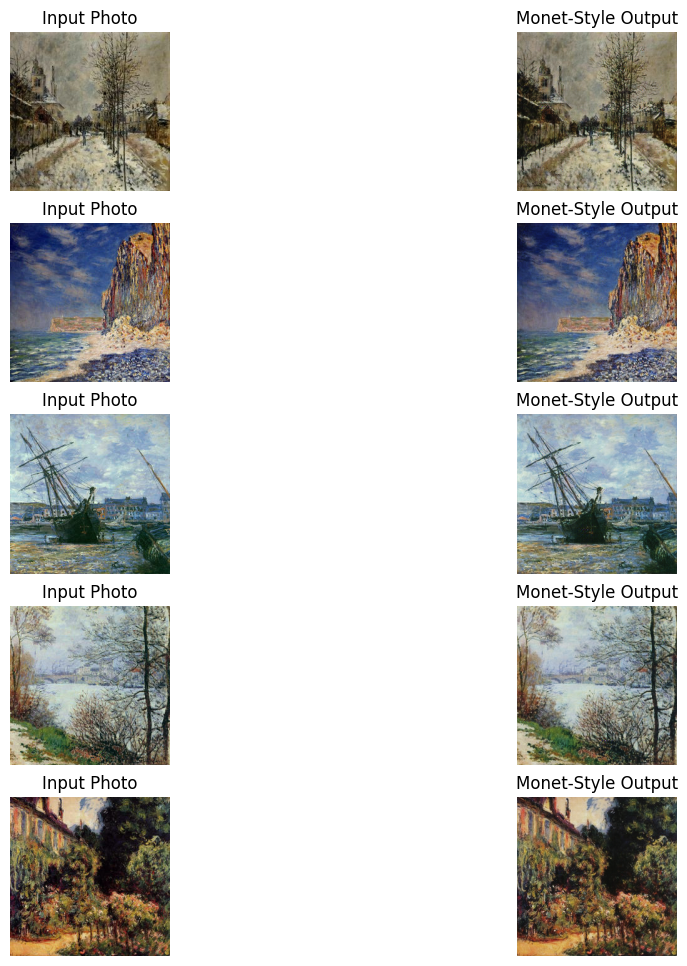

In [26]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_tfrec.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-Style Output")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

---

# **8. Conclusion**

This project used the CycleGAN (Cycle-Consistent Generative Adversarial Network) deep learning model for image-to-image translation and style conversion of input photographs to Monet-style output images.

30 epochs were used when training the CycleGAN model. The generator component of the model tended to improve with a greater number of epochs and was lowest at the 30th epoch. In contrast, the discriminator component of the model was lowest earlier on, at the first epoch.

In the future, the model can be improved by using more complex CNN architectures and fine tuning the hyperparameters of the CycleGAN model even more, as well as increasing the number of epochs the model is trained on.

---

# **9. Submission**

In [29]:
import PIL
! mkdir ../images

In [27]:
i = 1
for img in photo_tfrec:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [28]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'